# 1. 기본 설정

In [1]:
# 라이브러리 로드

import time
start_time = time.time() # 시작시간 기록

import tensorflow as tf
import numpy as np
import tensorflow as tf
from matplotlib.pylab import rcParams
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

from IPython import display

In [2]:
# 경로 지정
home_path = r'C:/Users/user/Desktop/AIFFEL/Day29/gan_cifar10_#'
current_try = '01'
current_path = os.path.join(home_path+current_try)
sample_path = os.path.join(current_path+'/sample_epoch_{:04d}_iter_{:03d}.png')
history_path = os.path.join(current_path + '/training_history/train_history_{:04d}.png')
checkpoint_dir = os.path.join(current_path+'/training_checkpoints')

#plt.savefig(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
# 파라미터 설정
BUFFER_SIZE = 50000  # 이미지 숫자. 고정.
BATCH_SIZE = 512

# Discriminator model
dr_1 = 0.3
dr_2 = 0.3

# 3. 생성자 모델 구현
# cross_entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전과정을 확인할 수 있으므로, 고정된 seed 노이즈 생성. -> 100차원의 노이즈 16개.
noise_dim = 100
num_examples_to_generate = 16

# 저장 변수
save_every = 10

# 훈련 횟수
EPOCHS = 500


In [3]:
# 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

In [4]:
# bit depth 확인. [0, 255]
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 255-127.5 : [0, 255] -> [-127.5, 127.5]
# / 127.5 : [-127.5, 127.5] -> [-1, 1]

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
print('(이미지 갯수, 가로 픽셀수, 세로 픽셀수, 컬러 포맷):', train_x.shape)

(이미지 갯수, 가로 픽셀수, 세로 픽셀수, 컬러 포맷): (50000, 32, 32, 3)


In [8]:
print(type(train_x[0]))
print(train_x[0])

<class 'numpy.ndarray'>
[[[-0.5372549  -0.51372549 -0.50588235]
  [-0.6627451  -0.63921569 -0.64705882]
  [-0.60784314 -0.62352941 -0.6627451 ]
  ...
  [ 0.23921569  0.03529412 -0.15294118]
  [ 0.19215686 -0.01960784 -0.2       ]
  [ 0.16078431 -0.02745098 -0.19215686]]

 [[-0.8745098  -0.84313725 -0.84313725]
  [-1.         -1.         -1.        ]
  [-0.85882353 -0.9372549  -1.        ]
  ...
  [-0.03529412 -0.30980392 -0.56862745]
  [-0.06666667 -0.34901961 -0.60784314]
  [-0.04313725 -0.31764706 -0.55294118]]

 [[-0.80392157 -0.81176471 -0.83529412]
  [-0.8745098  -0.94509804 -1.        ]
  [-0.61568627 -0.78823529 -0.9372549 ]
  ...
  [-0.0745098  -0.34117647 -0.60784314]
  [-0.05882353 -0.34117647 -0.60784314]
  [-0.14509804 -0.42745098 -0.67058824]]

 ...

 [[ 0.63137255  0.33333333 -0.24705882]
  [ 0.57647059  0.2        -0.73333333]
  [ 0.55294118  0.2627451  -0.79607843]
  ...
  [ 0.25490196  0.04313725 -0.45098039]
  [-0.56078431 -0.75686275 -0.94509804]
  [-0.58431373 -0.73

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


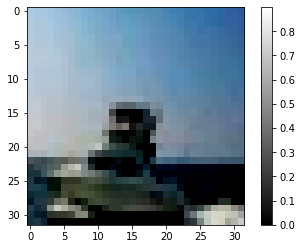

In [10]:
# reshape 굳이 써야할 이유가 없다.
plt.imshow(train_x[100], cmap='gray')
#plt.imshow(train_x[100].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

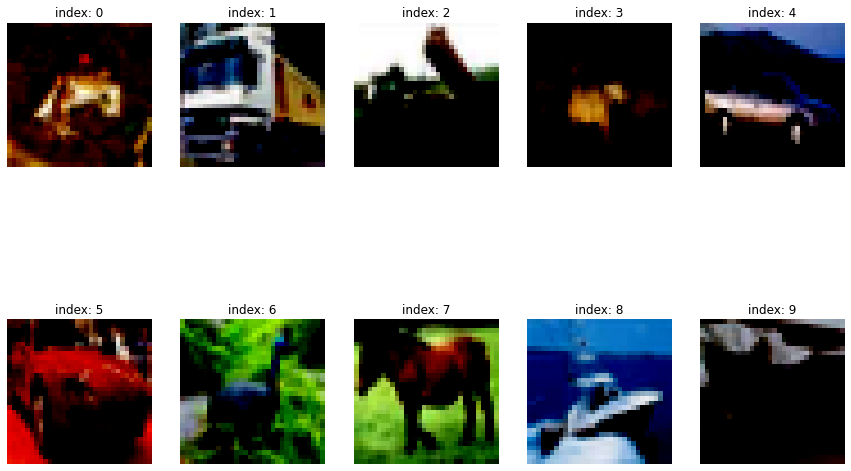

In [12]:
# (가로, 세로)의 캔버스 생성
plt.figure(figsize=(15, 10))


for i in range(10):
    
    # 2행 5열, i번째의 서브 캔버스 생성
    plt.subplot(2, 5, i+1)
    # 훈련데이터의 i번째 이미지 출력
    plt.imshow(train_x[i], cmap='gray')
    #plt.imshow(train_x[i].reshape(32, 32, 3), cmap='gray')
    # 타이틀에 인덱스 출력
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

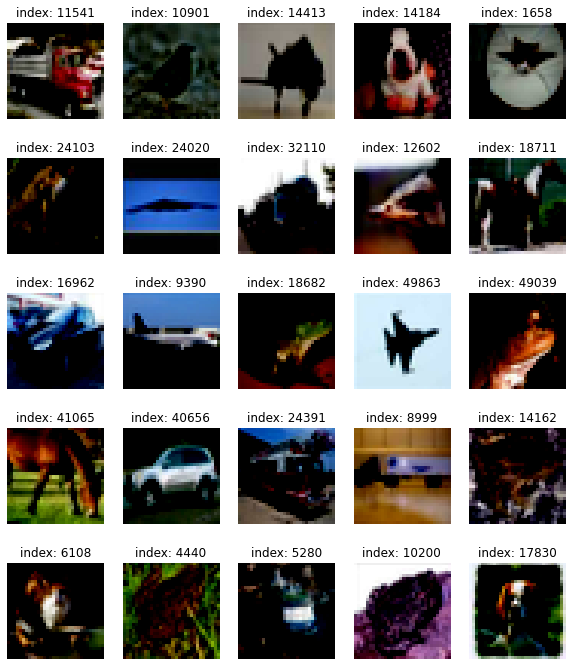

In [13]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    
    # 랜덤인덱스 생성 : 1~50000 사이에서.
    random_index = np.random.randint(1, 50000)
    
    # 랜덤인덱스의 순서에 따라 이미지 출력
    plt.imshow(train_x[random_index], cmap='gray')
    #plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [14]:
# 훈련데이터셋을 버퍼크기 만큼 섞은 배치에 따라 텐서 슬라이스로 만듬.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3. 생성자 모델 구현
- (32, 32, 3)의 형태를 가진 이미지를 생성하는 생성자 모델 구현 함수
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성.
- 생성된 랜덤 이미지가 생성자 출력 규격에 맞는지 확인.

In [15]:
def make_generator_model():

    # start
    model = tf.keras.Sequential()

    # first: Dense layer
    model.add(layers.Dense(8*8*256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # second: reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2D transpose layer # Transpose를 하는 이유는 무엇인가?
    model.add(layers.Conv2DTranspose(128, kernel_size = (5,5), strides = (1, 1), padding = 'same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2D Transpose layer
    model.add(layers.Conv2DTranspose(64, kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2D Transpose layer
    model.add(layers.Conv2DTranspose(3, kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh'))
  
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [16]:
# 노이즈 생성
noise = tf.random.normal([1, 100])
# noise를 바탕으로 신규 이미지 생성
generated_image = generator(noise, training = False)
print(generated_image.shape)

(1, 32, 32, 3)


In [17]:
print(noise)

tf.Tensor(
[[-1.024208    0.1092308  -0.8342871  -1.3058287  -1.2583711  -0.31498712
   0.6112763   0.2110033   1.4231447  -0.30216083  0.189464    0.9426071
   0.97367996 -0.8595958  -2.2740974   0.13454099  0.39729616 -0.55937266
   0.4455029  -0.06310841  1.4379787   0.8023771  -0.8628431   0.9040841
   0.3359543  -0.05394191  1.3899783  -0.83924186 -0.69870687 -0.59027904
  -0.53185594  1.0720607   1.6021864  -1.1449467  -0.478203    0.43192813
  -0.13347587 -0.7232997   0.03995878  0.3952886   2.9074159   0.07937262
   0.41919008 -0.4521753   1.9459546   0.8482947   0.39888814  0.6430876
   0.90302205 -0.00335686 -0.5105539  -0.6207918  -1.0161154   0.21791954
  -1.2243924   1.1337007  -0.88387346  1.6990958   0.23481898  0.53933144
   0.4844158  -0.2022105  -0.17233771 -2.2059526   1.1776084   0.3486691
  -1.1189038  -1.3083278   0.54349905  1.8369837   1.1519066  -0.8313724
  -1.555918    0.13639133  1.415316    1.2165326   0.70735735 -0.3691719
  -0.5043521   1.6701247  -1.3752

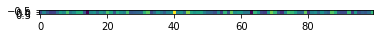

In [18]:
plt.imshow(noise)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


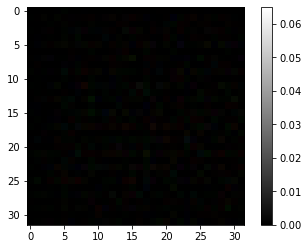

In [19]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0, :, :, :], cmap = 'gray')
plt.colorbar()
plt.show()

# 4. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별 결과를 출력하는 판별자 모델 구현함수.
- step2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인.

In [20]:
def make_discriminator_model():

    # start
    model = tf.keras.Sequential()

    # first: Conv2D layer
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dr_1))

    # second: Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dr_2))
    
    # third: Flatten layer
    model.add(layers.Flatten())

    # fourth: dense layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [21]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0002807]], dtype=float32)>

# 5. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현.
- 판별자의 출력값을 가지고 실제/생성 이미지 판별 정확도를 계산하는 함수 구현
- 생성자와 판별자를 최적화하는 optimizer 정의

In [22]:
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
vector = [[1,2,3],
          [4,5,6]]

# vector와 형태가 같은 1 행렬 생성
tf.ones_like(vector)  

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>

In [23]:
tf.constant([0.5])
print(tf.constant([0.5]))

tf.Tensor([0.5], shape=(1,), dtype=float32)


In [24]:
# 생성자 손실함수
def generator_loss(fake_output):
    
    # 가짜 출력을 받아 같은 형태의 1벡터를 생성한 것과의 크로스 엔트로피 계산 및 출력
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 판별자 손실함수
def discriminator_loss(real_output, fake_output):
    
    # 실제 출력을 받아 같은 형태의 1벡터를 생성한 것과의 크로스 엔트로피 계산.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    
    # 가짜 출력을 받아 같은 형태의 1벡터를 생성한 것과의 크로스 엔트로피 계산 및 출력
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # 종합 손실 = 진짜의 손실 + 가짜의 손실
    total_loss = real_loss + fake_loss
    return total_loss

# 판별 정확도 계산함수
def discriminator_accuracy(real_output, fake_output):
    
    # tf.constant: 상수 생성
    # tf.math.greater_equal: 왼쪽이 오른쪽보다 크거나 같으면 True, 아니면 False
    # tf.cast: 텐서를 새로운 형태로 캐스팅한다. 
    # tf.reduce_mean: 배열 내 차원을 제거하고 모든 원소들의 평균을 구한다.
    
    # 진짜의 정확도
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    
    # 가짜의 정확도
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy
                   

# 학습이 매번 어떻게 진행되어가고 있는지 확인하기 위해 생성자가 생성한 샘플 확인 -> 1번에 16장 생성.


seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
print(seed)

tf.Tensor(
[[-0.8004157   2.0336194   0.4038752  ...  0.6550104   0.4822946
   0.3557542 ]
 [-1.0895702   0.54111516  0.5732103  ... -0.77874964  0.29283506
  -0.77320814]
 [ 0.6800583   0.28286153 -0.0778924  ...  0.84496915  0.27050376
  -1.2169538 ]
 ...
 [-0.23270881 -1.1568984  -0.74853146 ... -1.2354048   1.6035657
   0.07081791]
 [ 0.6910369   0.27846265 -0.16439846 ...  2.0484807  -1.277046
   0.43871102]
 [ 0.86660314 -1.8736353  -0.1900854  ...  0.6543283  -0.18092082
  -0.24683218]], shape=(16, 100), dtype=float32)


# 6. 훈련과정 상세 기능 구현
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현.
- 16개의 고정된 seed를 입력으로 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images()함수를 구현.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성 이미지 판별 accuracy 히스토리를 그래프로 시각화하는 draw_train_history() 함수 구현.
- training_checkpoints 디렉토리에 몇 epoch 마다 모델을 저장하는 checkpoint 모듈 설정.

In [26]:
# 1개의 미니 배치의 훈련 과정을 처리
@tf.function
def train_step(images):

    # 생성자 입력 노이즈. 기본: (100 x 16)
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # 노이즈로부터 이미지 생성
        generated_images = generator(noise, training = True)
        
        # 원본으로부터 진위 판별, 생성 이미지로부터 진위 판별
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        # 생성이미지의 판별값으로부터 생성 손실 계산
        gen_loss = generator_loss(fake_output)
        # 원본 판별 값과 생성 판별값으로 판별 손실 계산
        disc_loss = discriminator_loss(real_output, fake_output)

        # 원본 판별값과 생성 판별값으로 생성 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    # 생성자 그래디언트에 생성 손실과 이 때의 생성 훈련변수 그래디언트를 기록
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # 판별자 그래디언트에 판별 손실과 이 때의 판별 훈련변수 그래디언트를 기록
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 생성자 그래디언트와 생성 훈련변수를 새 그래디언트에 반영하여 생성자 최적화.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # 판별자 그래디언트와 판별 훈련변수를 새 그래디언트에 반영하여 판별자 최적화.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 생성 손실, 판별 손실, 진짜의 정확도, 가짜의 정확도 반환
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

# 16개의 고정된 seed를 입력받아 훈련과정 동안 생성한 이미지를 4x4 개 출력
def generate_and_save_images(model, epoch, it, sample_seeds):

    # 생성자모델 생성
    predictions = model(sample_seeds, training = False)

    fig = plt.figure(figsize = (4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :], cmap = 'gray')
        plt.axis('off')
    
    plt.savefig(sample_path.format(epoch, it))
    plt.show()

# 훈련시기마다 생성자/판별자의 loss 및 판별자의 실제/생성 이미지 판별 정확도 히스토리를 그래프로 시각화.
rcParams['figure.figsize'] = 15, 6   # matlab 차트의 기본 크기를 15, 6으로 지정

def draw_train_history(history, epoch):

    # 손실 로그 요약
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc = 'upper left')

    # 정확도 로그 요약
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc = 'upper left')

    # training_history 디렉토리에 epoch별 그래프를 이미지 파일로 저장.
    plt.savefig(history_path.format(epoch))
    plt.show()

# training_checkpoint 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈 설정

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

# 7. 학습 과정 진행
- 위 step5에서 구현한 기능들을 활용하여 최소 50epoch만큼의 모델 학습을 진행.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif파일을 통해 학습 진행 과정을 시각적으로 표현.
- 학습 과정을 담은 샘플 이미지, gif파일, 학습 진행 그래프 이미지 제출. 
- gif를 통해 생성이미지 품질이 서서히 향상되는 것을 확인.
- fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인.

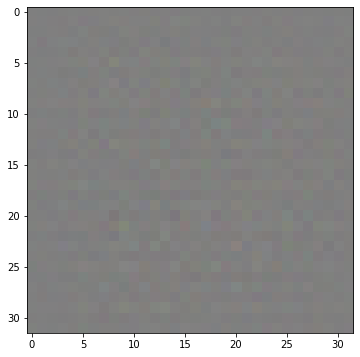

In [27]:
# 최근의 체크포인트
latest = tf.train.latest_checkpoint(checkpoint_dir)
# 최근의 체크포인트 복원
checkpoint.restore(latest)

# 생성자에 대해 체크포인트 기록
generator = checkpoint.generator
# 판별자에 대해 체크포인트 기록
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인

#100개의 변수를 가진 노이즈 생성
noise = tf.random.normal([1, 100])
# 노이즈로부터 이미지 생성
generated_image = generator(noise, training = False)
# 생성된 이미지를 배열화
np_generated = generated_image.numpy()

# 정규화 복원. [-1, 1] -> [0, 255]
np_generated = (np_generated * 127.5) + 127.5  
# 복원한 이미지를 정수화.
np_generated = np_generated.astype(int)
# 만든 이미지를 출력
plt.imshow(np_generated[0])
plt.show()

In [29]:
total = current_path+ '/sample_epoch_{:04d}_iter_{:03d}.png'
total

'C:/Users/user/Desktop/AIFFEL/Day29/gan_cifar10_#01/sample_epoch_{:04d}_iter_{:03d}.png'

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy': [], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait = True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {}: {} sec'.format(epoch+1, int(time.time() - epoch_start)))

        if (epoch +1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training: {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

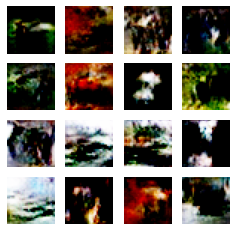

Time for training: 53169 sec


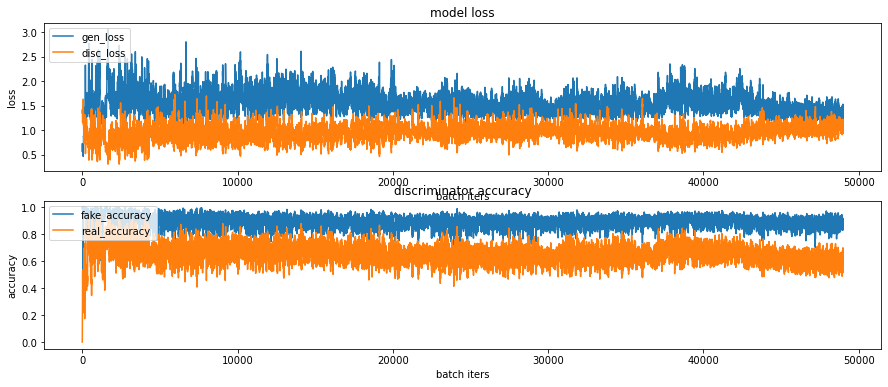

Wall time: 14h 46min 11s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

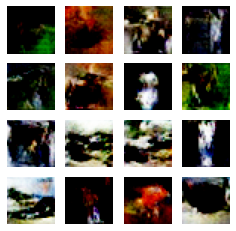

Time for training: 4975 sec


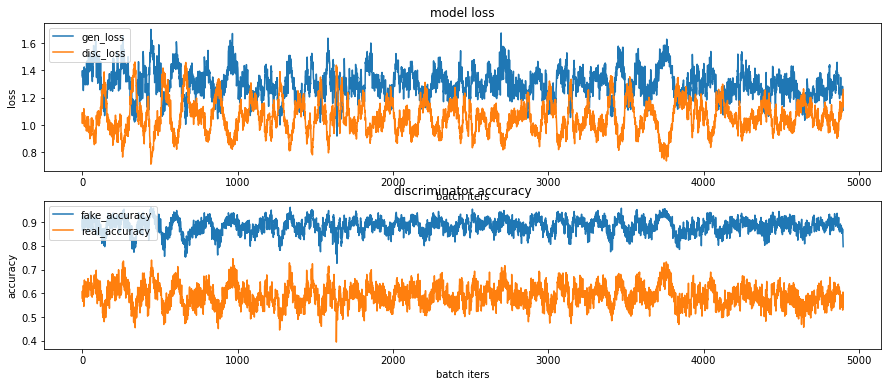

In [36]:
# 추가 수행 1
addtional_start = time.time()
dr_1 = 0.5
EPOCHS = 50


train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = (additional - additional_end)//60
print(f'작업의 총 소요시간은 약{addtional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

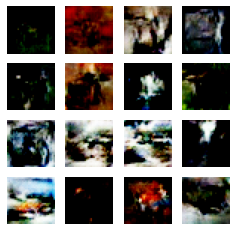

Time for training: 4786 sec


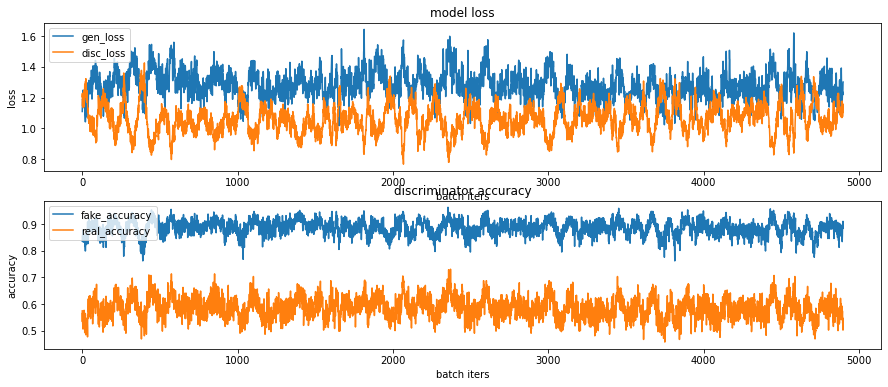

NameError: name 'additional' is not defined

In [37]:
# 추가 수행 2
addtional_start = time.time()
dr_2 = 0.5
EPOCHS = 50


train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = (additional - additional_end)//60
print(f'작업의 총 소요시간은 약{addtional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

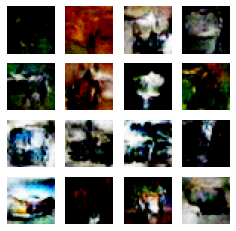

Time for training: 4931 sec


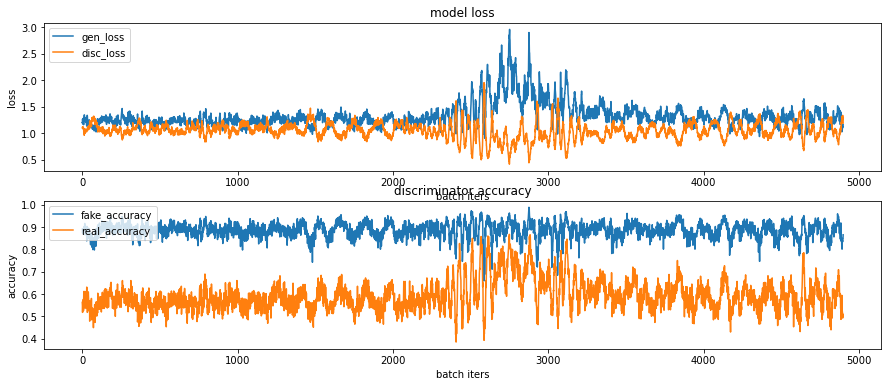

NameError: name 'additional_start' is not defined

In [40]:
# 추가 수행 3
addtional_start = time.time()
dr_1 = 0.1
dr_2 = 0.3
EPOCHS = 50

#%%time
train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = (additional_start - additional_end)//60
print(f'작업의 총 소요시간은 약{addtional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

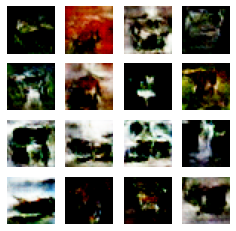

Time for training: 5331 sec


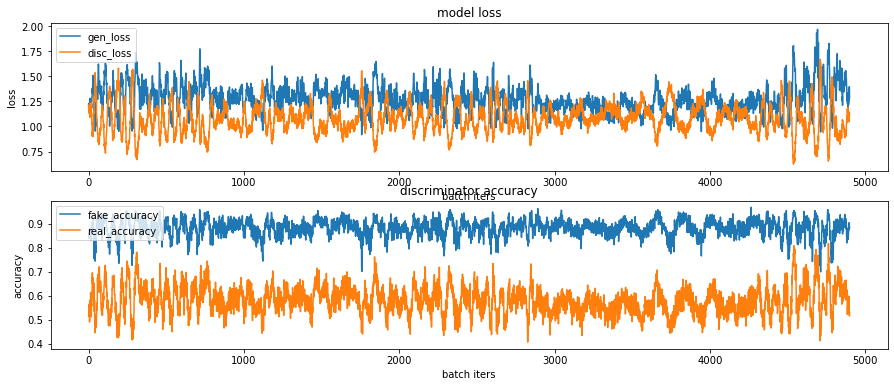

NameError: name 'addtional_work_time' is not defined

In [41]:
# 추가 수행 4
additional_start = time.time()
dr_1 = 0.7
dr_2 = 0.3
EPOCHS = 50


train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = (additional_start - additional_end)//60
print(f'작업의 총 소요시간은 약{additional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

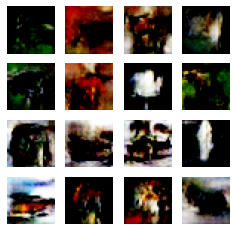

Time for training: 4992 sec


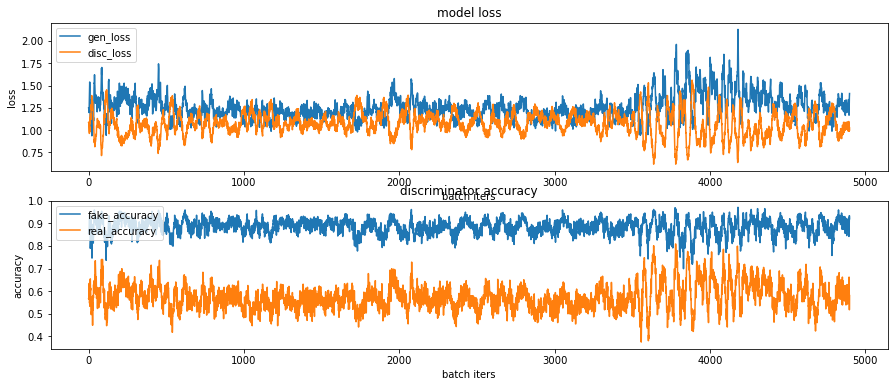

작업의 총 소요시간은 약-84.0분입니다.


In [42]:
# 추가 수행 5
additional_start = time.time()
dr_1 = 0.3

EPOCHS = 50
# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Nadam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = (additional_start - additional_end)//60
print(f'작업의 총 소요시간은 약{additional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

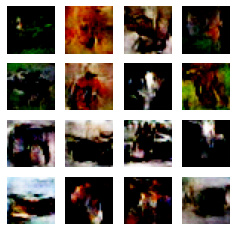

Time for training: 4875 sec


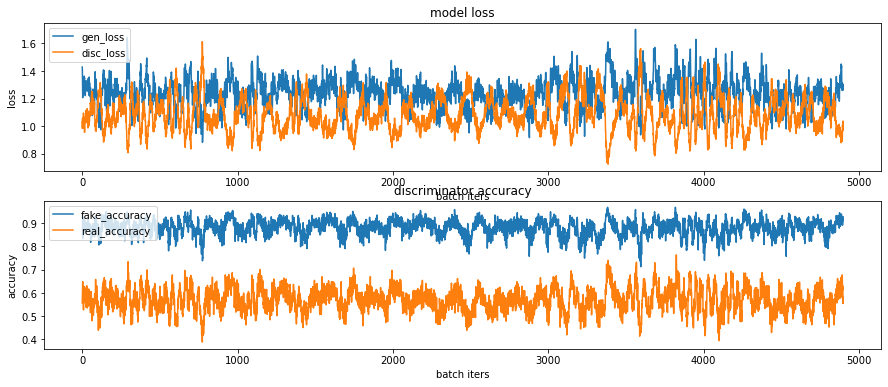

작업의 총 소요시간은 약 -82분입니다.


In [43]:
# 추가 수행 6
additional_start = time.time()
dr_1 = 0.3

EPOCHS = 50
# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Nadam(1e-4)

train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = int((additional_end - additional_start)//60)
print(f'작업의 총 소요시간은 약 {additional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

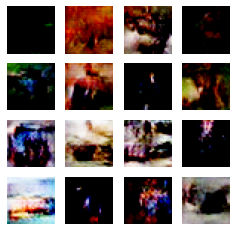

Time for training: 4661 sec


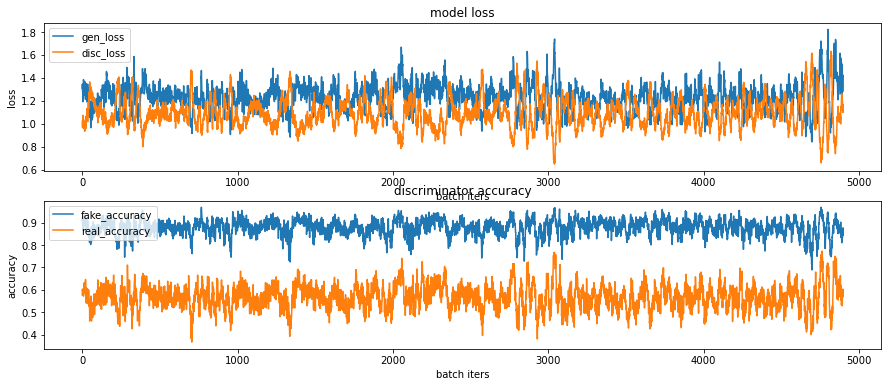

작업의 총 소요시간은 약 77분입니다.


In [44]:
# 추가 수행 7
additional_start = time.time()

EPOCHS = 50
# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Nadam(1e-6)
discriminator_optimizer = tf.keras.optimizers.Nadam(1e-6)

train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = int((additional_end - additional_start)//60)
print(f'작업의 총 소요시간은 약 {additional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

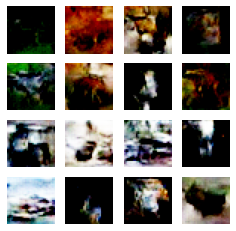

Time for training: 5201 sec


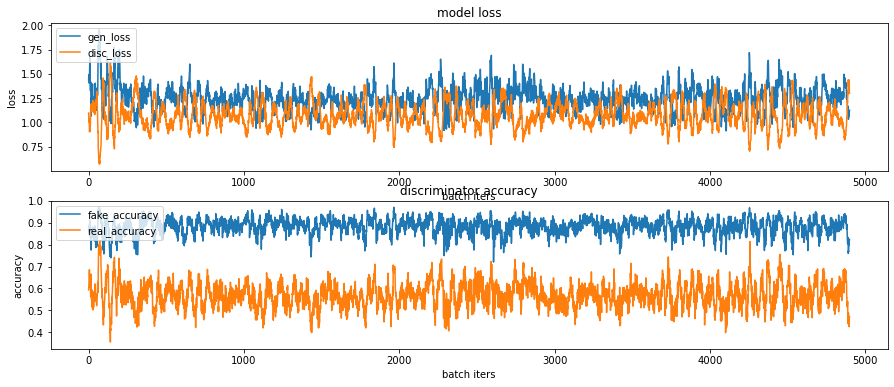

작업의 총 소요시간은 약 86분입니다.


In [45]:
# 추가 수행 8
additional_start = time.time()

EPOCHS = 50
# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Nadam(1e-1)
discriminator_optimizer = tf.keras.optimizers.Nadam(1e-1)

train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = int((additional_end - additional_start)//60)
print(f'작업의 총 소요시간은 약 {additional_work_time}분입니다.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

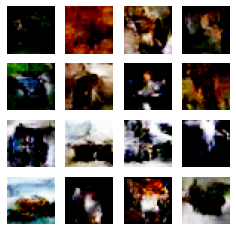

Time for training: 5683 sec


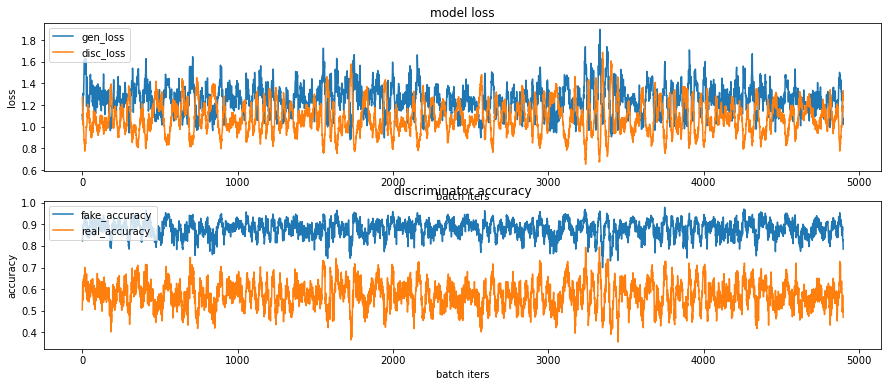

작업의 총 소요시간은 약 94분입니다.
Wall time: 1h 34min 43s


In [46]:
%%time
# 추가 수행 9
additional_start = time.time()

EPOCHS = 50
# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Nadam(1e-10)
discriminator_optimizer = tf.keras.optimizers.Nadam(1e-10)

train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = int((additional_end - additional_start)//60)
print(f'작업의 총 소요시간은 약 {additional_work_time}분입니다.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

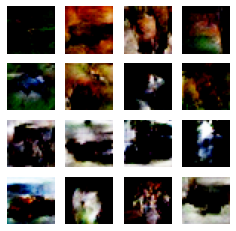

Time for training: 19242 sec


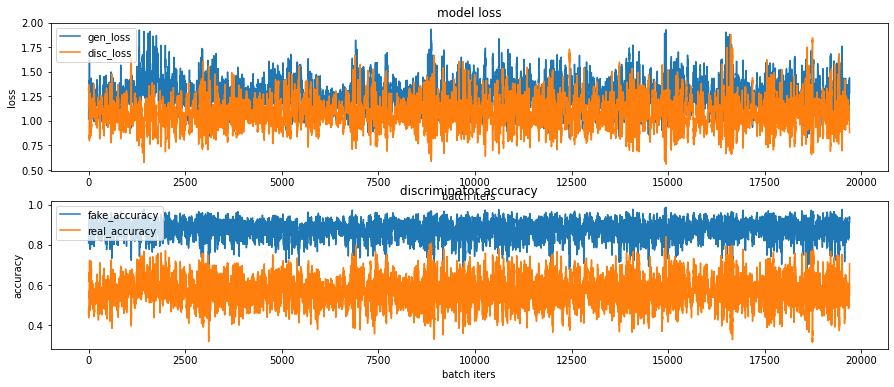

작업의 총 소요시간은 약 320분입니다.
Wall time: 5h 20min 43s


In [47]:
%%time
# 추가 수행 10
additional_start = time.time()

EPOCHS = 201
# 생성자 최적자, 판별자 최적자
generator_optimizer = tf.keras.optimizers.Adam(1e-10)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-10)

train(train_dataset, EPOCHS, save_every)
additional_end = time.time()
additional_work_time = int((additional_end - additional_start)//60)
print(f'작업의 총 소요시간은 약 {additional_work_time}분입니다.')

# Rubric
- 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다 -> 오브젝트 종류를 육안으로 구별할 수 있을만한 이미지를 생성하였다.
- 2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. -> gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
- 3. 추가적인 GAN 모델 구조 혹은 학습 과정 개선 아이디어를 제안하고 이를 적용하였다 -> 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

# 회고
- 기본 파라미터로 500epoch 수행 후 추가 훈련을 수행하였다. 변동사항만 기재한다.
- 추가1: dr_1 0.3 -> 0.5, 50epoch
- 추가2: dr_2 0.3 -> 0.5, 50epoch
- 추가3: dr_1 0.5 -> 0.1, dr_2: 0.5 -> 0.3, 50epoch
- 추가4: dr_1 0.1 -> 0.7, 50epoch
- 추가5: generator_optimizer Adam -> Nadam, 50epoch
- 추가6: generator_optimizer Nadam -> Adam, discriminator_optimizer Adam -> Nadam, 50epoch
- 추가7: generator_optimizer Adam -> Nadam, learning_rate 모두 1e-4 -> 1e-6, 50epoch
- 추가8: learning_rate 모두 1e-6 -> 1e-1, 50epoch
- 추가9: learning_rate 모두 1e-1 -> 1e-10, 50epoch
- 추가10: optimizer 모두 Nadam -> Adam, 201epoch

- 추가수행 결과, 기본 파라미터 수행결과와 크게 다르지 않아 보인다. 위의 파라미터 변경은 크게 영향을 주지 않는 것으로 보인다.
- 이에 별도 파일로 생성자 모델을 5개 -> 13개 레이어로 추가 구성하여 500epoch진행해 보았다.
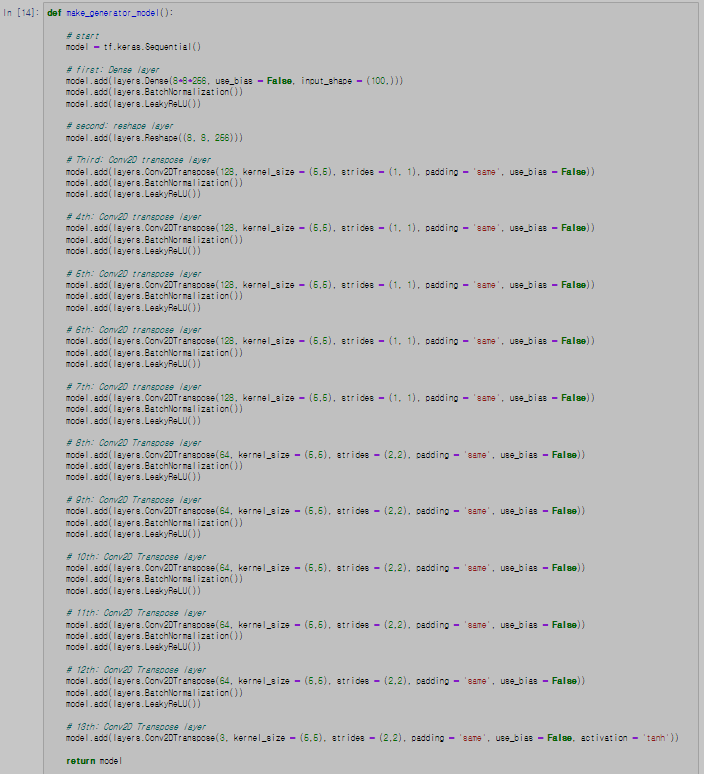

- 이에 대한 결과 이미지는 다음과 같다.
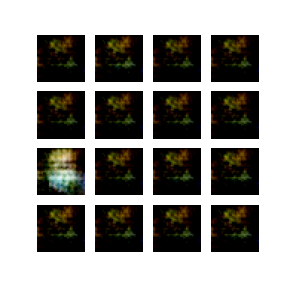

- 히스토리는 다음과 같다.
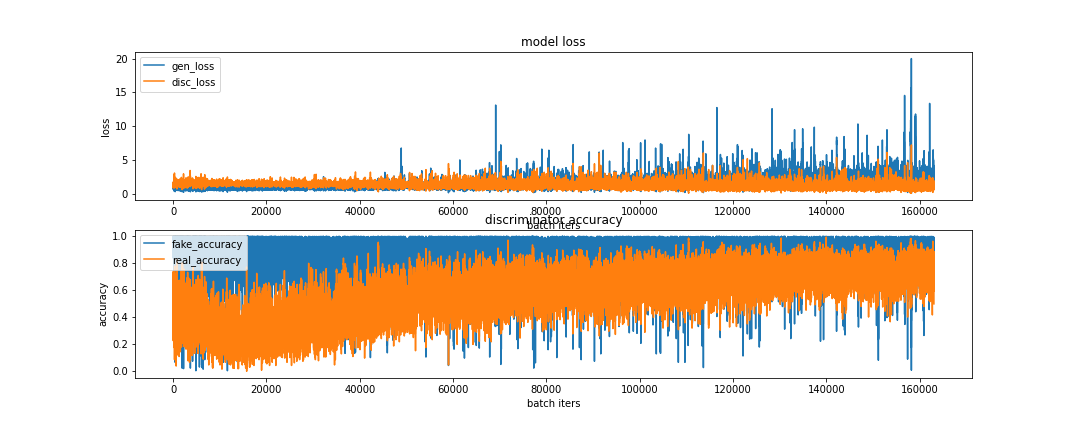
- 히스토리에서 알 수 있듯, fake_accuracy가 이따금 0.5 근처값이 나오기는 하나, 추세상 0.5를 향한다고 보기는 어렵다. 그리고 이미지도 나오지 않았다. 
- 기본 모델의 결과보다 더 좋지 않았는데, 이유는 더 찾아보아야겠으나 모델이 틀려서 그럴 가능성보다는 훈련횟수가 아직 부족해서 그렇지 않을까 생각한다.
- 하지만 좀 더 수행하기엔 시간 제한이 있으므로 아쉬움을 삼키고 제출한다.



## 마침